In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/digits',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


In [4]:
print(ds_info)


tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/digits/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Digits
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\pc\\tensorflow_datasets\\emnist\\digits\\3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=120.32 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    super

In [5]:
def preprocess(image, label):
    # EMNIST images might be transposed/rotated depending on source; ensure correct orientation
    # image is uint8 (28,28,1) or (28,28)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [28, 28, 1])
    # EMNIST sometimes stores rotated digits — rotate if needed (comment out if not)
    # image = tf.image.rot90(image, k=1)
    return image, label


In [6]:
IMG_SHAPE = (28, 28, 1)
BATCH = 128

# AUTOTUNE allows TensorFlow to automatically decide the best number of parallel threads
AUTOTUNE = tf.data.AUTOTUNE
# Apply the preprocessing function to every (image, label) pair in the dataset.
# This converts raw EMNIST images into normalized (0–1), reshaped (28x28x1) tensors
# and does so efficiently using parallel processing (AUTOTUNE).
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)

# Preprocess the test dataset the same way to ensure consistency between training and evaluation.
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)

In [7]:
# ---------------------------------------------------------
# DATA AUGMENTATION (adds realistic variation to digits)
# ---------------------------------------------------------
# These layers randomly rotate, shift, and zoom images during training.
# This helps the model generalize better to real handwritten digits,
# which are never perfectly centered or perfectly straight.
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08),            # rotate digits up to ±4.5 degrees
    layers.RandomTranslation(0.06, 0.06),   # shift digits horizontally & vertically by 6%
    layers.RandomZoom(0.08),                # zoom in/out by ~8%
])


# ---------------------------------------------------------
# BUILD TRAINING DATA PIPELINE
# ---------------------------------------------------------
# 1. Shuffle: randomizes sample order (prevents learning patterns in dataset order)
# 2. Batch: groups images into batches of size BATCH (128)
# 3. Map: applies augmentation on the fly to every batch
# 4. Prefetch: prepares next batch in background → speeds up training
ds_train = (
    ds_train
    .shuffle(10000)                                 # randomize training samples
    .batch(BATCH)                                   # create batches of 128 images
    .map(lambda x, y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)               # apply augmentation to each batch
    .prefetch(AUTOTUNE)                             # overlap data loading + GPU work
)


# ---------------------------------------------------------
# BUILD TEST DATA PIPELINE
# ---------------------------------------------------------
# Only batching + prefetching (no augmentation, because test data must stay clean)
ds_test = (
    ds_test
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,330 (1.50 MB)

 Trainable params: 391,370 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9177 - loss: 0.2681
Epoch 1: val_accuracy improved from None to 0.98941, saving model to emnist_cnn_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 103s 54ms/step - accuracy: 0.9615 - loss: 0.1264 - val_accuracy: 0.9894 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9825 - loss: 0.0580
Epoch 2: val_accuracy improved from 0.98941 to 0.99098, saving model to emnist_cnn_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 99s 53ms/step - accuracy: 0.9840 - loss: 0.0538 - val_accuracy: 0.9910 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9865 - loss: 0.0446
Epoch 3: val_accuracy improved from 0.99098 to 0.99156, saving model to emnist_cnn_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.9869 - loss: 0.0433 - val_accuracy: 0.9916 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 4/30
187

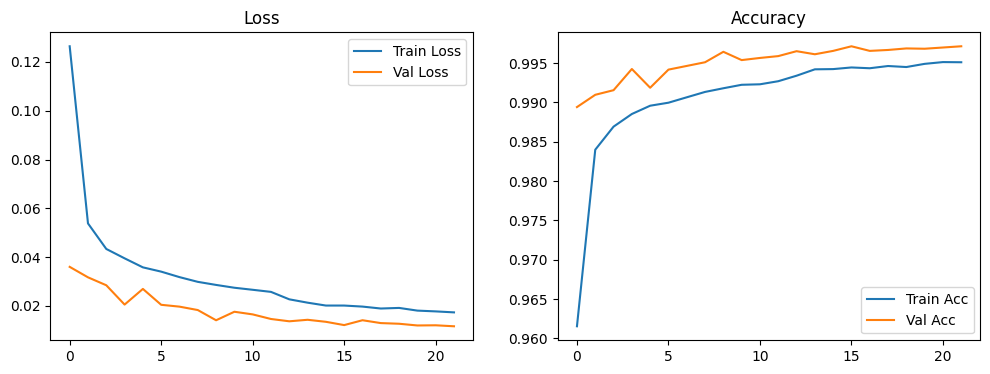

In [7]:
def build_emnist_model():
    model = models.Sequential([
        layers.Input(shape=IMG_SHAPE),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    return model
model = build_emnist_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint('emnist_cnn_model.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    ds_train,
    validation_data=ds_test.take(200),  # small validation slice from test for monitoring
    epochs=30,
    callbacks=[checkpoint, early, reduce_lr]
)

eval_res = model.evaluate(ds_test)
print("Test loss/acc:", eval_res)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()




In [8]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


NameError: name 'model' is not defined